<h2> Infrastructure </h2>

In [ ]:
# Constant IC Current Reference Test Code - Adapted by Shawn Newman

In [41]:
# Tips:  
  
# VSCode:
#    * Outline button is in the row of buttons right above this. Much easier navigation.
#    * Click on the blue bar to the left of a cell to hide it. Also works on outputs
#
# Jupyter Notebook:
#    * [View->Table of contents] for the outline
#    * You can click the arrow to the left of headings to collapse/expand their section
#
# Structure:
#    * The first code cell should run all the cells that simply define/import things
#    * The headings in the outline with an asterisk are the ones that actually use those functions, 
#      constants, and libraries to do things. You'll manually run those.
#    * Don't click the little "init" buttons in the bottom left of cells, it erases the tag
#
# Misc:
#    * [ctrl+Enter] runs a cell
#    * Select multiple lines of code, then press [ctrl+/] to comment or uncomment all 
#      (I just discovered this a couple months ago and am mad about it)

<h3>* Initialize All Functions and Libraries</h3>

In [3]:
# Turn on File->'Auto Save' if you want to use this. Reads cell data from disk.
# This runs every cell in here with the tag "init". Library imports, function definitions, constants, etc.
# Saves a lot of time

import nbformat # Library for manipulating notebooks

def execute_cells_by_tag(group_tag, quiet=True):
    filepath = globals()['__vsc_ipynb_file__'] # Returns path to this file
    if (quiet==False): print(filepath)
    nb = nbformat.read(open(filepath, 'r', encoding='utf-8'), as_version=4) # Saves this notebook as JSON
    ip = get_ipython()                                                      # Gets the "global InteractiveShell instance"
    if (quiet==False): print(ip)
    for cell_number in range(len(nb.cells)):
        cell=nb.cells[cell_number]
        #print(cell)
        if 'tags' in cell.metadata:
            if group_tag in cell.metadata.tags:
                ip.run_cell(cell.source)
                if (quiet==False): print(f"Ran Cell {cell_number}")

execute_cells_by_tag('init')

Imported Libraries
ICASL is loaded!
Initialized Constants:
Trigger Count = 1801
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Plotting Functions
Initialized Full Procedure


<h3> Import Libraries </h3>

In [2]:
import pyvisa                            # Instrument communication
import time                              # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt          # Plotting graphs and visualizing data
from matplotlib.ticker import LogLocator # Used for ticks in logarithmic plots
import numpy as np                       # Numerical operations, particularly with arrays
import pandas as pd                      # Data manipulation and analysis
import os                                # Interact with the operating system, such as handling file paths
import importlib.util                    # Used to load python files more dynamically

print("Imported Libraries")

Imported Libraries


In [44]:
# import ICASL.py
# print("Imported ICASL from this directory")
# ICASL.test()

In [3]:
# Loads ICASL.py from a higher directory
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

ICASL is loaded!


<h3> * Constants </h3>

In [6]:
DEVICE_NAME = "Constant-IC_Current_Reference" # GLOBAL directory
SET_PRECISION = .5  # How close the probe's temperature needs to get to the SET value before soak time begins (in Celsius)
SETTLING_TIME = .15 # Default wait time between setting values and measuring
# Required SETTLING_TIME will vary depending on the circuit. If there's a lot of sweeps, it can make the tests take much longer.
SOAK_TIME = 360  # How long to soak at temperature (in seconds). Blalock recommended 5 minutes. Longer now because of bad temp probing.
NPLC = 1
LOG = False

# Calcs
def calc_trigger_count(start, stop, step):
    trigger_count = int(abs((start-stop)/step))+1
    if LOG: print(f"Trigger Count = {trigger_count}")  
    return trigger_count

print("Initialized Constants:")

# Defaults
VDD_DEFAULT = 1.8
IREF_DEFAULT = 0
CURRENT_RANGE = 1e-4

# Sweeps
VDD_MAX = VDD_DEFAULT
VDD_MIN = 0
VDD_STEP = 0.001
TRIGGER_COUNT_DEFAULT = calc_trigger_count(VDD_MAX, VDD_MIN, -VDD_STEP)
print(f"Trigger Count = {TRIGGER_COUNT_DEFAULT}") # Currently unused

VREF_MAX = VDD_DEFAULT
VREF_MIN = 0
VREF_STEP = 0.001

GLOBAL_TEMPS = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]  

# Which Tests to run
TEST_VDD_DOWN = False
TEST_VDD_UP = False
TEST_IREF = True
COLD_START = False

Initialized Constants:
Trigger Count = 1801


<h2> Equipment </h2>

In [5]:
# Enable full pyvisa logging
pyvisa.log_to_screen()

In [6]:
# Disable full pyvisa logging
import logging
pyvisa.log_to_screen(level=logging.INFO)

In [7]:
# TODO: ADD POWER SUPPLIES TO TESTING CODE (need physical connections first)

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    if query != "NONE":
        print(instrument.query(query))           # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    return instrument

print("Initialized Equipment's Establish Connection")

Initialized Equipment's Establish Connection


<h3>* Connect Equipment </h3>

In [2]:
# Corresponding voltages/currents are in the names of equipment
# For a device with multiple channels, list each channel's voltage/current in order
# Everything except the temp chamber needs to be powered on beforehand.
rm = pyvisa.ResourceManager() 
SM_IREF = establish_connection('GPIB6::20::INSTR', '*IDN?')
SM_VDD = establish_connection('GPIB6::21::INSTR', '*IDN?')
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
GPIBInstrument at GPIB6::21::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636504,B02 Jan 20 2021 10:19:49/B01  /W/N
GPIBInstrument at GPIB6::6::INSTR
YNNNYYYYNNNNNNNNNN0


Equipment Info

In [ ]:
# To find IDs

# Waveform Generators: System -> I/O Settings -> USB
# Multimeters:
# SourceMeters:
# Sun Chamber: 'GPIB6::6::INSTR'

# Temperature Chamber Status Code

# Y = power is on
# 2: Y = command error last command
# 3: Y = time out LED is on
# 4: Y = waiting for timeout
# 5: Y = heat output is enabled
# 6: Y = cool output is enabled
# 7: Y = valid set temperature
# 8: Y = deviation limit exceeded
# 9: Y = currently ramping
# 10: Y = chamber temp < lower limit
# 11: Y = chamber temp > upper limit
# 12: Y = waiting at a BKPNT
# 13: Y = in LP run mode
# 14: Y = in LP remote store mode
# 15: Y = in local edit LP mode
# 16: Y = waiting to run LP at TOD
# 17: Y = GPIB bus timeout
# 18: Y = in local keyboard lockout mode
# 19: 0 = system Self Test was OK
# 1 = Battery RAM error found (check default settings)
# 2 = EE RAM error found (check probe calibration)
# 3 = ROM error found (call factory)

<h3> Equipment Functions </h3>

In [ ]:
####### Temperature Chamber #######

def chamber_init():
    CHAMBER.write("ON")                  # Also turns on heat and cool (unless configured otherwise)
    CHAMBER.write("RATE={CHAMBER_RATE}") # Sets the speed at which the chamber will ramp to change temp
    CHAMBER.write("WAIT=FOREV")          # Sets the time that the chamber will wait once the desired temperature is reached before moving to next temp. We don't use this.
    CHAMBER.write("HON")                 # Turns heat on (just in case)
    CHAMBER.write("CON")                 # Turns cool on (just in case)
    CHAMBER.write("PIDA=3")              # Switches to monitoring user probe when setting temperature (DUT will reach temperature, not the top of the chamber)
    time.sleep(1) 
    #print(CHAMBER.query("RATE?"))
    #print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Figure out when SCPI needs leading colons (never?)
# TODO: Switch to using full names for SCPI commands

# Initializations

def SM_reset(SM):
    # Full reset to factory defaults
    # Turns off output!
    SM.write("*RST")

def SM_clear(SM):
    # Clear Errors
    SM.write("*CLS")
    # Clear trace buffers and triggers
    SM.write("TRAC:CLE")
    SM.write("TRIG:CLE")  
    SM_set_trigger_defaults(SM)            
    
def SM_init(SM, current_limit):
    SM_clear(SM)
    SM.write("SYST:BEEP:STAT OFF")              # Turn off the beeper on the SMU
    SM.timeout = 150000                         # Set timeout for SMU operations
    SM.write("SYST:AZER ON")                    # Enable auto-zero
    SM.write("SOUR:FUNC VOLT")                  # Set source function to voltage
    SM.write("SENS:FUNC 'CURR'")                # Set measurement function to current
    SM.write(f"SOUR:VOLT:RANG {VDD_MAX}")          
    SM.write(f"SENS:CURR:PROT {current_limit}") # Set current protection (compliance)
    SM.write(f"SENS:CURR:RANG {current_limit}") # Set current range
    SM.write(f"SENS:CURR:NPLC {NPLC}")                # Set NPLC for current measurement to 1  

def SM_set_trigger_defaults(SM):
    # FD - Factory Default. RST command should set all of this as well.
    SM.write("ARM:COUN 1")                     # (FD) 
    SM.write("ARM:SOUR IMM")                   # (FD) Arm's source set to immediate - i.e. your device
    SM.write("ARM:DIR ACC")                    # (FD) Arm direction = acceptor
    SM.write("ARM:OUTP NONE")                  # (FD)
    SM.write(f"TRIG:COUN 1")                   # (FD) Set trigger count to match sweep points
    SM.write("TRIG:SOUR IMM")                  # (FD) Immediate trigger source for the leader FD is IMM
    SM.write("TRIG:DEL 0")                     # (FD) Delay 
    SM.write("TRIG:DIR ACC")                   # (FD) Trigger direction acceptor 

def SM_set_trigger_leader(SM):
    SM.write("TRIG:SOUR TLIN")                 # Immediate trigger source for the leader FD is IMM
    SM.write("TRIG:INP SENS")
    SM.write("TRIG:OUTP SOUR") # Set trigger output to Trigger Link
    SM.write("TRIG:OLIN 1") # Trigger Link output line
    SM.write("TRIG:ILIN 2") # Trigger Link input line

def SM_set_trigger_follower(SM):
    SM.write("TRIG:SOUR TLIN")                 # Immediate trigger source for the leader FD is Trigger link
    SM.write("TRIG:INP SOUR")
    SM.write("TRIG:OUTP DEL")
    SM.write("TRIG:OLIN 2")
    SM.write("TRIG:ILIN 1")
    SM.write("INIT")

# Sweeps

def SM_set_sweep_leader(SM, start, stop, step, delay):
    SM_clear(SM_VDD)
    if ((stop-start)/step < 0):
        step = step*-1 # Ensure correct step polarity
        if LOG: print(f"Step size: {step}")
    SM.write(f":SOUR:DEL {delay}")
    SM.write("SOUR:VOLT:MODE SWE")        # Set source mode to sweep
    SM.write(f"SOUR:VOLT:START {start}")        
    SM.write(f"SOUR:VOLT:STOP {stop}")           
    SM.write(f"SOUR:VOLT:STEP {step}")           
    SM.write(":SOUR:SWE:SPAC LIN")        # Set the sweep spacing to linear, meaning the voltage will increase linearly between steps.
    SM.write("OUTP ON")                   # Enable output - this sets the equipment to the start voltage until sweep is triggered later

    # Set up Trigger Link for leader
    # You need a Trigger Link cable for this!
    SM_set_trigger_defaults(SM)
    SM.write(f"TRIG:COUN {calc_trigger_count(start, stop, step)}") # Set trigger count to match sweep points. FD is 1
    SM_set_trigger_leader(SM)

def SM_set_sweep_follower(SM, value, trigger_count):
    SM_clear(SM)
    SM_set_fixed(SM, value)

    # Set up Trigger Link for follower
    SM_set_trigger_defaults(SM)
    SM.write(f"TRIG:COUN {trigger_count}")     # Set trigger count to match sweep points. FD is 1
    SM_set_trigger_follower(SM)

# On/Off

def SM_set_fixed(SM, level):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write(f"SOUR:VOLT:LEV {level}")
    SM.write("OUTP ON")

def SM_off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write(":OUTP OFF")

####### Groupings #######
# Do not interact with temperature chamber

def initialize_all():
    SM_init(SM_VDD, current_limit=3.5e-4)
    SM_init(SM_IREF, current_limit=1.5e-4)

def clear_all():
    SM_clear(SM_VDD)
    SM_clear(SM_IREF)

def turn_on_all():
    SM_set_fixed(SM_VDD, VDD_DEFAULT)
    SM_set_fixed(SM_IREF, IREF_DEFAULT)
    time.sleep(.1)

def turn_off_all():
    SM_off(SM_VDD)
    SM_off(SM_IREF)
    time.sleep(.1)

def measure_all():
    # Will not work if trigger link is initialized, so:
    SM_set_trigger_defaults(SM_VDD)
    SM_set_trigger_defaults(SM_IREF)
    SM_VDD.query(":READ?")
    SM_IREF.query(":READ?")

def measure_all_continuously(time_between):
    try:
        SM_set_trigger_defaults(SM_VDD)
        SM_set_trigger_defaults(SM_IREF)
        while(True):
            time.sleep(time_between)
            SM_VDD.query(":READ?")
            SM_IREF.query(":READ?")
    except KeyboardInterrupt:
        pass

def kick_start():
    turn_off_all()
    time.sleep(20)
    turn_on_all()

print("Initialized Equipment Functions")

Initialized Equipment Functions


<h3>* Test Equipment </h3>

In [3]:
# Test SourceMeters
SM_init(SM_VDD, current_limit=2.5e-4)
print(SM_VDD.query(":CONF?"))
SM_init(SM_IREF, current_limit=1e-4)
print(SM_IREF.query(":CONF?"))

"CURR:DC"
"CURR:DC"


In [4]:
turn_on_all()

In [6]:
measure_all()

In [7]:
turn_off_all()

<h2> Plotting </h2>

In [ ]:
# ICASL.start_plot() defines global default plotting parameters. Has a couple styles built in.
# local_start_plot() defines default plotting parameters for this specific file. So if you want to change something about all of these
# plots, you could either add code before the call to ICASL or eliminate the call to ICASL and write your own function entirely.
# These are essentially middle managers
def local_start_plot(title, xlabel, ylabel):
    fig, ax = ICASL.start_plot(title, xlabel, ylabel)
    return fig, ax

def local_finish_plot(fig, ax, save_dir="none", save_file="none", cm=plt.get_cmap('gist_rainbow'), legend=None, legend_style="None", annotations=None, close=True, show=False):
    # legend = ax.legend(bbox_to_anchor=(1.02, 1))
    # legend_style = "b"
    ICASL.finish_plot(fig, ax, save_dir=save_dir, cm=cm, save_file=save_file, legend=legend, legend_style=legend_style, annotations=annotations, close=close, show=show)

print("Initialized Plotting Default Styling")

Initialized Plotting Default Styling


<h3> Plotting Functions </h3>

In [24]:
def plot_all(read_dir, write_dir, plot_temps):
    # Potential bug: if passing a single plot_temp not stored in a list, then when these functions 
    # try to iterate over it, they might fail
    if (TEST_VDD_UP):
        VDD_plot(read_dir, write_dir, plot_temps, "Up", "IDD")
        VDD_plot(read_dir, write_dir, plot_temps, "Up", "IREF")

    if (TEST_VDD_DOWN):
        VDD_plot(read_dir, write_dir, plot_temps, "Down", "IDD")
        VDD_plot(read_dir, write_dir, plot_temps, "Down", "IREF")

    if (TEST_VDD_UP and TEST_VDD_DOWN):
        VDD_hysteresis_plot(read_dir, write_dir, plot_temps, "IDD")
        VDD_hysteresis_plot(read_dir, write_dir, plot_temps, "IREF")

    if (TEST_IREF):
        IREF_plot(read_dir, write_dir, plot_temps)
        temp_plot(read_dir, write_dir, plot_temps, "IREF", ["","V(IREF)=0V"])

def VDD_plot_init(title, x_label, y_label):
    fig, ax = local_start_plot(title, x_label, y_label)
    ax.set_xticks(ICASL.arange(VDD_MIN, VDD_MAX, 0.2))
    ax.set_xlim(VDD_MIN, VDD_MAX)
    return fig, ax

# Potential bug - scaling is performed on each temp independently. If different temps
# end up in different Engineering Notation regions, the values would misalign.
def VDD_plot(read_dir, write_dir, plot_temps, direction, current):
    if (direction != "Up" and direction != "Down"): raise ValueError(f"Invalid direction: {direction}. Must be 'Up' or 'Down")
    if (current != "IDD" and current != "IREF"): raise ValueError(f"Invalid current: {current}. Must be 'IDD' or 'IREF")
    
    # I use this for dynamic scaling into engineering notation that's consistent for all lines on the plot
    all_currents = []
    for temp in plot_temps:
        df = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_{direction}.csv"))
        df = ICASL.fix_dataframe(df)
        for value in df[current].values:
            all_currents.append(value)

    fig, ax = VDD_plot_init(f"VDD {direction}ward Sweep", "VDD Voltage (V)", f"{current} (mA)")
    for temp in plot_temps:
        df = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_{direction}.csv"))
        df = ICASL.fix_dataframe(df)
        ax.plot(df["VDD"], ICASL.scale_by(df[current], all_currents), label=f"T={temp} °C")
    ax.set_ylabel(f'{current} Current ({ICASL.prefix(all_currents)}A)', fontdict={'fontsize': 12})
    local_finish_plot(fig, ax, write_dir, f"VDD_Sweep_{direction}_{current}.png")

def VDD_hysteresis_plot(read_dir, write_dir, plot_temps, current):
    if (current != "IDD" and current != "IREF"): raise ValueError(f"Invalid current: {current}. Must be 'IDD' or 'IREF")
    for temp in plot_temps:
        fig, ax = VDD_plot_init(f"VDD Hysteresis Sweep T={temp} °C", "VDD Voltage (V)", f"{current} (mA)")
        df_up = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_Up.csv"))
        df_down = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"VDD_Sweep_Down.csv"))
        df_up = ICASL.fix_dataframe(df_up)
        df_down = ICASL.fix_dataframe(df_down)

        all_currents = []
        for val in df_up[current].values:
            all_currents.append(val)
        for val in df_down[current].values:
            all_currents.append(val)
        ax.plot(df_up["VDD"], ICASL.scale_by(df_up[current], all_currents), label=f"Upwards Sweep")
        ax.plot(df_down["VDD"], ICASL.scale_by(df_down[current], all_currents), label=f"Downwards Sweep")
        ax.set_ylabel(f'{current} Current ({ICASL.prefix(all_currents)}A)', fontdict={'fontsize': 12})
        local_finish_plot(fig, ax, write_dir, f"VDD_Hysteresis_Sweep_{current}_temp={temp}.png", cm=None)

def IREF_plot_init():
    fig, ax = local_start_plot("IREF Sweep", "VREF (V)", "IREF (mA)")
    ax.set_xticks(ICASL.arange(VREF_MIN, VREF_MAX, 0.2))
    ax.set_xlim(VREF_MIN, VREF_MAX)
    return fig, ax

def IREF_plot(read_dir, write_dir, plot_temps):
    fig, ax = IREF_plot_init()

    all_currents = []
    for temp in plot_temps:
        df = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"IREF_Sweep.csv"))
        df = ICASL.fix_dataframe(df)
        for value in df["IREF"].values:
            all_currents.append(value)
    
    for temp in plot_temps:
        df = ICASL.read_csv(os.path.join(read_dir, f"temp={temp}", f"IREF_Sweep.csv"))
        df = ICASL.fix_dataframe(df)
        ax.plot(df["VREF"], ICASL.scale_by(df["IREF"], all_currents), label=f"T={temp} °C")
    ax.set_ylabel(f'IREF Current ({ICASL.prefix(all_currents)}A)', fontdict={'fontsize': 12})
    print("MAKING PLOT")
    local_finish_plot(fig, ax, save_dir=write_dir, save_file="IREF_Sweep.png", legend=ax.legend(bbox_to_anchor=(1.02, 1)))


def temp_plot_init(title, x_label, y_label, plot_temps):
    fig, ax = local_start_plot(title, x_label, y_label)
    ax.set_xticks(ICASL.arange(min(plot_temps), max(plot_temps), 25))
    #ax.set_xlim(min(plot_temps), max(plot_temps))
    return fig, ax

# temp,   current, voltage
# z_to_x, xy_to_y, xy_to_z
def temp_plot(read_dir, write_dir, plot_temps, current, annotations=None):
    if (current != "IDD" and current != "IREF"): raise ValueError(f"Invalid current: {current}. Must be 'IDD' or 'IREF")
    
    test_name = f"IREF_Sweep.csv"
    plot_Vs = [1.8]
    voltage = "VDD"

    all_currents = []
    dfs = {}
    for temp in plot_temps:
        path = os.path.join(read_dir, f"temp={temp}", test_name)
        df = ICASL.read_csv(path)
        df = ICASL.fix_dataframe(df)                 # If you remove rows you might leave NaN's behind - this clears those rows
        df[voltage] = df[voltage].round(3) # The equipment has a slight offset very often - 5*e^-5
        df = df[df[voltage].isin(plot_Vs)]    # Filters rows by Vs
        df = df.sort_values(by=voltage)
        # if LOG: print(f"df_Vs: {df[voltage]}")
        for df_V, V in zip(df[voltage], plot_Vs):
            if round(df_V, 2) != round(V, 2):
                raise ValueError(f"Plot_Vs' {V} does not match '{voltage}' column's {df_V} in {path}")
        
        # Stores all values so I can figure out what metric prefix they need to collectively use
        dfs[temp] = df
        for value in df[current].values:
            all_currents.append(value)

    fig, ax = temp_plot_init(f"{current} Temperature Sweep", "Temperature (°C)", f"{current} ({ICASL.prefix(all_currents)}A)", plot_temps)
    for V in plot_Vs:
        Is = []
        for temp in plot_temps:
            df = dfs[temp]
            for df_V, df_I in zip(df[voltage], df[current]):
                if round(df_V, 2) == round(V, 2):
                    Is.append(df_I)
                    break
        ax.plot(plot_temps, ICASL.scale_by(Is, all_currents), label=f"{voltage}={V} V")
    ax.set_ylabel(f'{current} Current ({ICASL.prefix(all_currents)}A)', fontdict={'fontsize': 12})
    save_file = f"{current}_Over_Temperature_Across_{voltage}.png"
    print("MAKING PLOT")
    #local_finish_plot(fig, ax, write_dir, save_file, legend=ax.legend(bbox_to_anchor=(1.02, 1)), annotations=annotations)
    local_finish_plot(fig, ax, write_dir, save_file)

print("Initialized Plotting Functions")

Initialized Plotting Functions


<h3>* Preview Plot Formatting </h3>

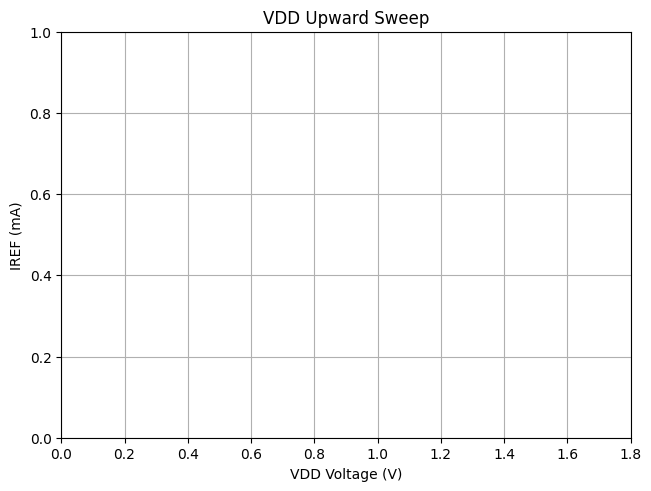

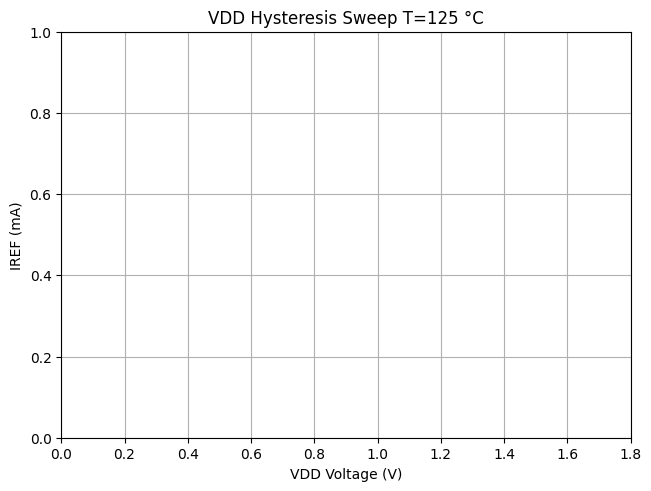

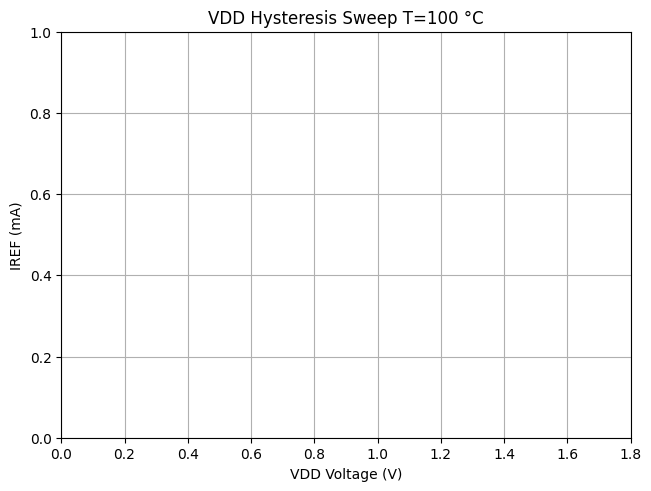

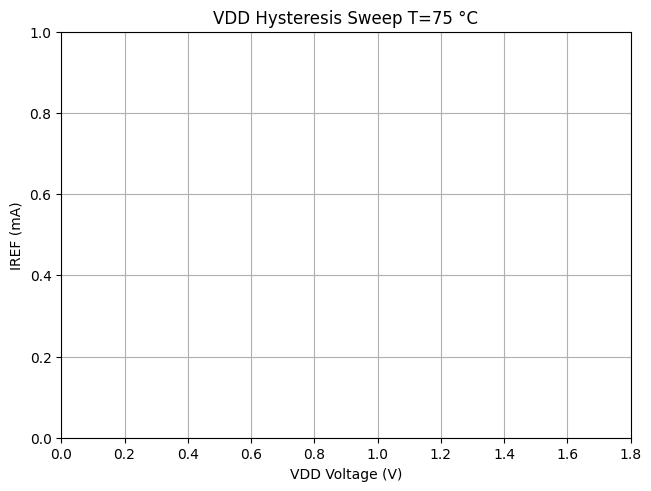

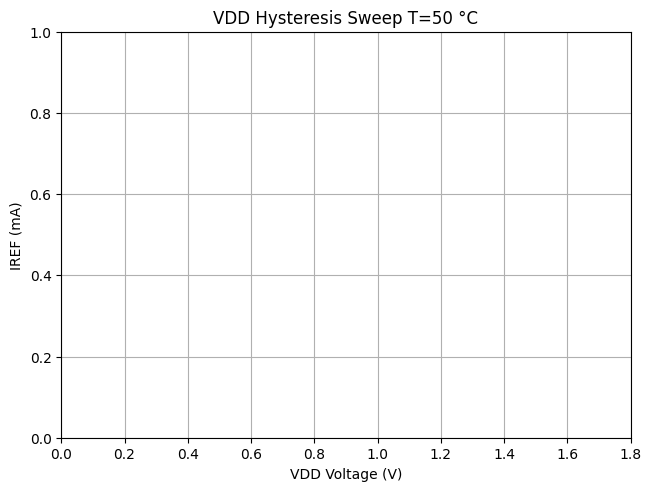

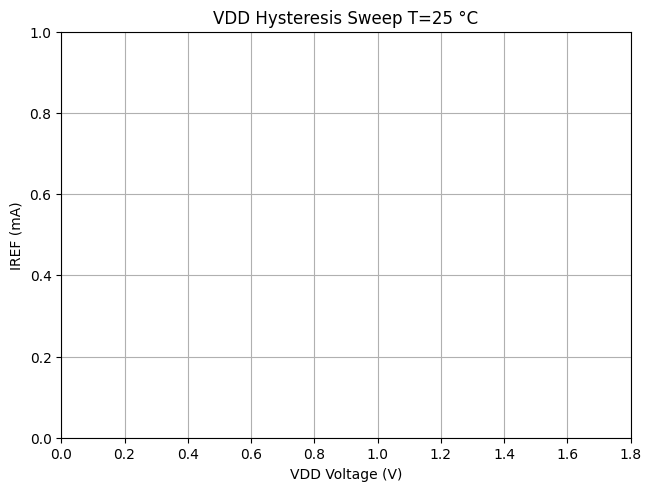

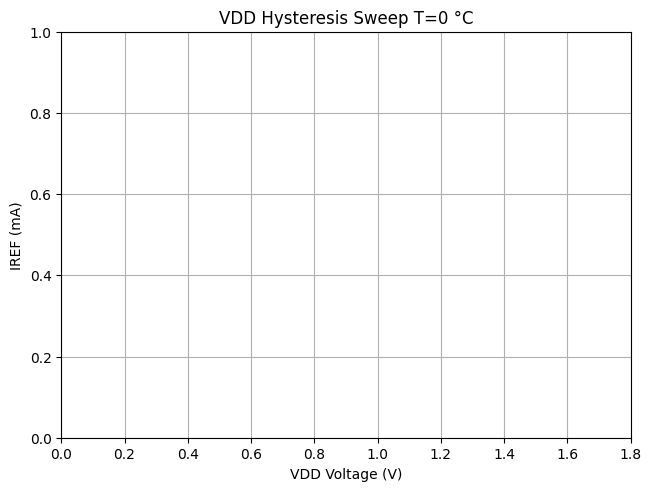

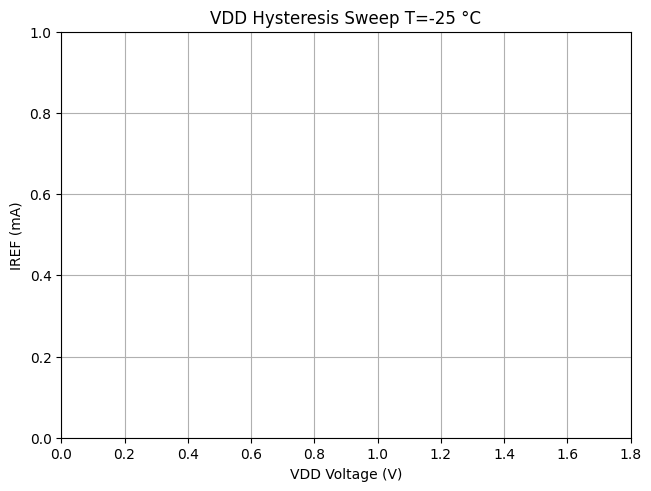

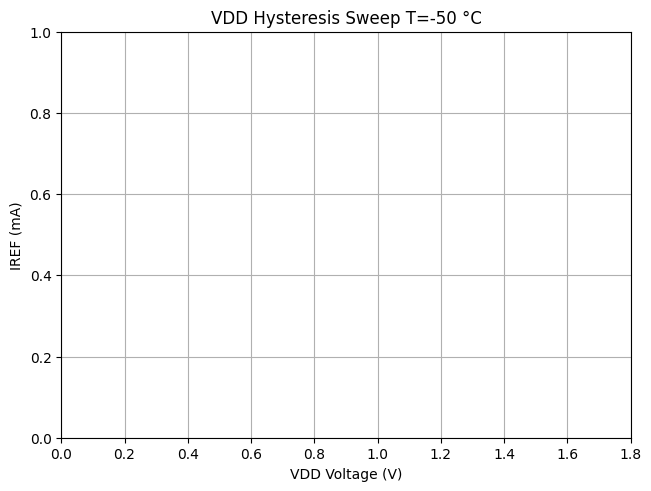

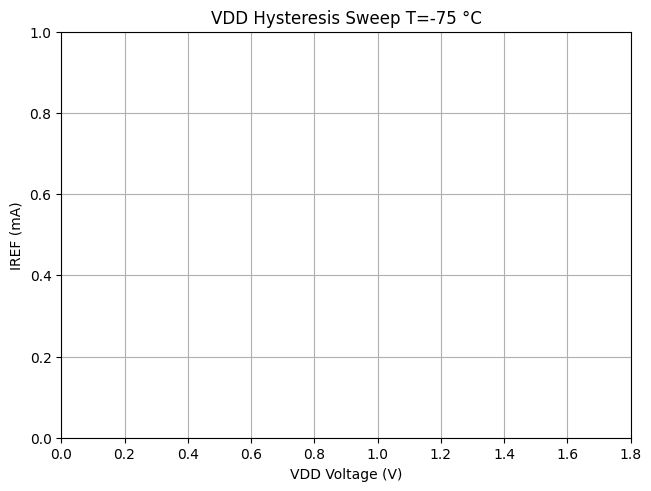

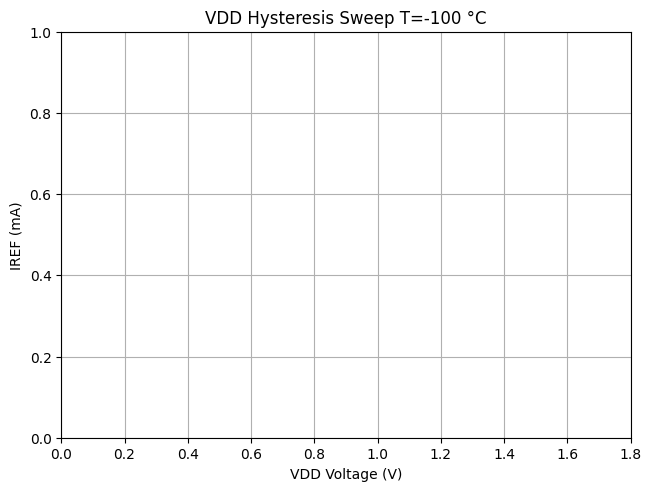

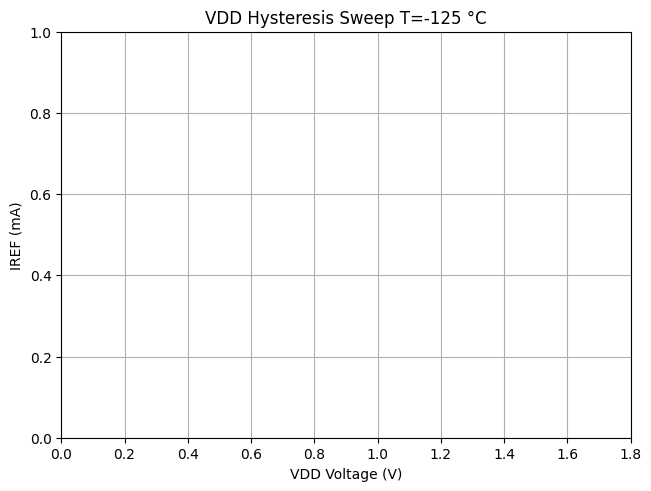

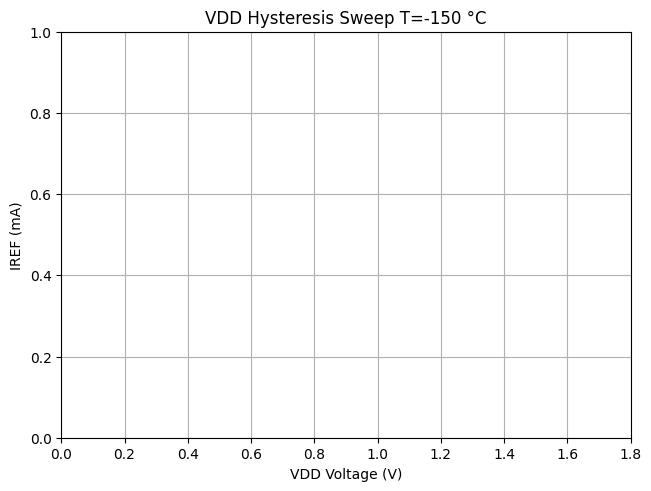

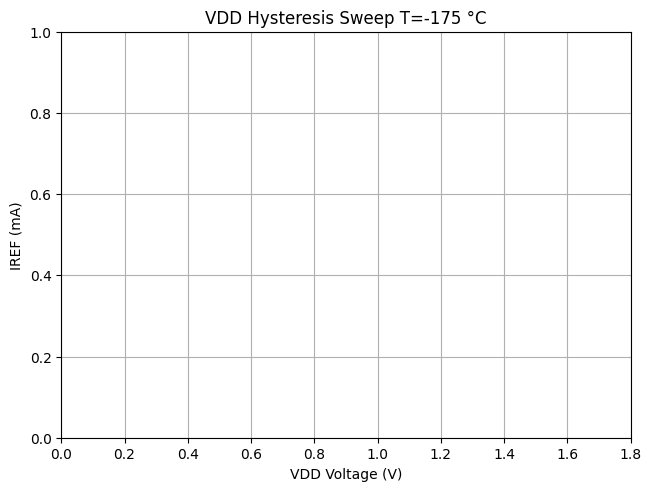

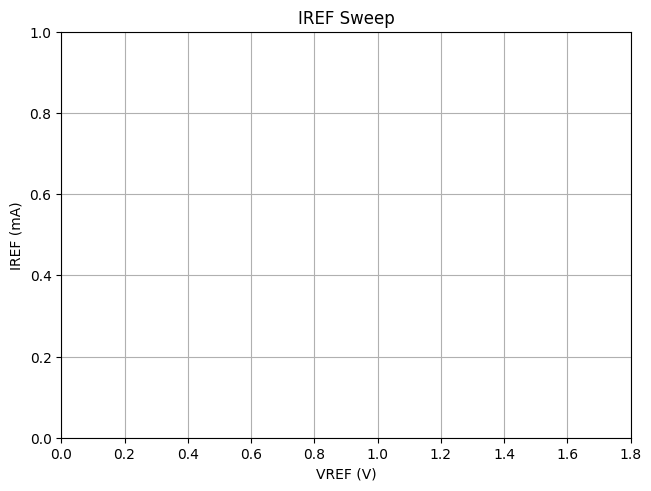

In [4]:
# Use this to print the formatting of all of your plots - not called during tests
# This is why plot initializations are separate
def initialize_all_plots(plot_temps):
    current = "IREF"
    VDD_plot_init(f"VDD Upward Sweep", "VDD Voltage (V)", f"{current} (mA)")
    for temp in plot_temps:
        VDD_plot_init(f"VDD Hysteresis Sweep T={temp} °C", "VDD Voltage (V)", f"{current} (mA)")
        pass # "pass" allows you to comment out the above line without python yelling at you for the loop doing nothing
    IREF_plot_init()
    plt.show()

initialize_all_plots(GLOBAL_TEMPS)

<h3>* Generate Experimental Plots </h3>

In [25]:
# Manual use - Not called during procedure

date = "2025-08-07" # Manually set 
run = "Experiment_4" # Manually set

read_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run) 
write_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run, "Plots_Generated_Later") # Make sure this doesn't overwrite anything important
plot_temps = ICASL.read_dir_values(read_dir, "temp")
print(plot_temps)

# dir = os.path.join("Combined_Data", "Combined_Experiment")
# read_dir = os.path.join(dir, "Combined_Temps")
# write_dir = os.path.join(dir, "Plots")
# os.makedirs(write_dir,exist_ok=True)

LOG = True
plot_all(read_dir, write_dir, plot_temps)
# IREF_plot(read_dir, write_dir, plot_temps)
# VDD_plot(read_dir, write_dir, plot_temps, "Up", "IDD")
# VDD_plot(read_dir, write_dir, plot_temps, "Up", "IREF")

[-150, -125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125]
MAKING PLOT
MAKING PLOT


<h2> Running Experiment </h2>

<h3> Individual Tests </h3>

In [ ]:
# Tests/Sweeps:

def run_tests(temp_dir):
    # Change these variables in the "Constants" tab near the top.
    if (TEST_VDD_DOWN): VDD_sweep(temp_dir, "Down")
    if (TEST_VDD_UP): VDD_sweep(temp_dir, "Up")
    if (TEST_IREF): IREF_output_sweep(temp_dir)


def VDD_sweep(save_dir, direction):
    # Equipment preparation for the sweep
    if direction == "Down": SM_set_sweep_leader(SM_VDD, VDD_MAX, VDD_MIN, -VDD_STEP, SETTLING_TIME)
    elif direction == "Up": SM_set_sweep_leader(SM_VDD, VDD_MIN, VDD_MAX, VDD_STEP, SETTLING_TIME)
    else: raise ValueError(f"Direction must be 'Up' or 'Down'. Cannot be '{direction}'")
    
    trigger_count = calc_trigger_count(VDD_MAX, VDD_MIN, -VDD_STEP)
    SM_set_sweep_follower(SM_IREF, 0, trigger_count)

    time.sleep(1)
    if LOG: print(f"Starting VDD sweep {direction}")
    VDD_data = SM_VDD.query("READ?").split(',')     # Initiate the sweep on VDD
    IREF_data = SM_IREF.query("FETC?").split(',')
    if LOG: print(f"Finished sweep, storing")

    # Store data
    df = pd.DataFrame({'VDD':VDD_data[0::5], 'IDD':VDD_data[1::5],
                       'VREF':IREF_data[0::5], 'IREF':IREF_data[1::5]})   # Create a DataFrame
    df.to_csv(os.path.join(save_dir, f'VDD_Sweep_{direction}.csv'), index=False)

def IREF_output_sweep(save_dir):
    # Equipment intialization/setting   
    #SM_set_sweep_leader(SM_IREF, VREF_MAX, VREF_MIN, -VREF_STEP, SETTLING_TIME)
    SM_set_sweep_leader(SM_IREF, VREF_MIN, VREF_MAX, VREF_STEP, SETTLING_TIME)

    trigger_count = calc_trigger_count(VREF_MAX, VREF_MIN, -VREF_STEP)
    SM_set_sweep_follower(SM_VDD, VDD_DEFAULT, trigger_count) 

    time.sleep(1)
    IREF_data = SM_IREF.query("READ?").split(',') # Initiate the sweep on IREF
    VDD_data = SM_VDD.query("FETC?").split(',')     

    # Store inner data
    df = pd.DataFrame({'VREF':IREF_data[0::5], 'IREF':IREF_data[1::5], 
                       'VDD':VDD_data[0::5], 'IDD':VDD_data[1::5]})   # Create a DataFrame
    df.to_csv(os.path.join(save_dir, f'IREF_Sweep.csv'), index=False)

    print("Initialized Test Functions")

# By the way, we're yet to test with the cold start organized like this.
def cold_start(run_dir):
    turn_off_all()   # Turn off voltages
    time.sleep(900)  # Wait 15 minutes for device to cool down
    turn_on_all()

    # Cold start data is stored in a subdirectory. This means it is ignored by default but can be
    # parsed identically by simply passing the subdirectory to functions rather than the higher directory
    run_dir_CS = os.path.join(run_dir, "Cold_Start")
    temp_dir_CS = os.path.join(run_dir_CS, "temp=-175")
    os.makedirs(temp_dir_CS, exist_ok=True)
    
    run_tests(temp_dir_CS)   
    plot_all(run_dir_CS, temp_dir_CS, [-175])

    turn_off_all()
    # Temperature Chamber is NOT off at this point. Close valve, let the pipes empty, then set it back to room temp.
    


<h3> Full Procedure </h3>

In [ ]:
#####################################################################################################################
################## IMPORTANT: Make sure all CHAMBER commands are contained with an if(USE_CHAMBER): #################
#####################################################################################################################

# USE_CHAMBER = True - turns on the temperature chamber and performs the temperature sweep
# USE_CHAMBER = False - performs a test run without interacting with the chamber.

def run_experiment(USE_CHAMBER, run_dir, local_temps=GLOBAL_TEMPS, additional_temps_to_plot=[]):
    
    ################## Temperature Sweep ##################
         
    temps_tested = additional_temps_to_plot
    for temp in local_temps:
        temp_dir = os.path.join(run_dir, f"temp={temp}") # The temperature of the experiment gets set as the sub-directory name
        os.makedirs(temp_dir, exist_ok=True) # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (USE_CHAMBER): 
            CHAMBER.write(f"SET={temp}")
            while(True):
                user_probe_temp = float(CHAMBER.query("USER?"))
                if (temp < -165 and user_probe_temp < -155 and temp < user_probe_temp):
                    CHAMBER.write("RATE=10")     # Slow chamber's rate of change. Seems to result in less LN2 spillage.
                    CHAMBER.write("HOFF")        # Stops chamber from heating. One time it applied a little heat at -175 and rapidly dropped the DUT temp.
                if (temp+SET_PRECISION >= float(user_probe_temp) >= temp-SET_PRECISION):
                    break
                time.sleep(10)
                measure_all() # Updates readings periodically during time between tests
                #print(CHAMBER.query("STATUS?"))
            print(f"{temp}: {CHAMBER.query("STATUS?")}")
            time.sleep(SOAK_TIME)

        # Tests
        if LOG: print(f"Performing Tests at temp {temp}")
        run_tests(temp_dir)
        if LOG: print("Finished Tests")

        rename = ICASL.rename_dir_once_plotted(run_dir, "No_Plots")
        if rename != None and isinstance(rename, str):
            run_dir = rename
            temp_dir = os.path.join(run_dir, f"temp={temp}") # The temperature of the experiment gets set as the sub-directory name
            time.sleep(3)
        temps_tested.append(temp)
        plot_all(run_dir, temp_dir, temps_tested) # Intermediate plots
    
    # Overall plots
    FINAL_PLOTS_DIR = os.path.join(run_dir, "Final_Plots")
    os.makedirs(FINAL_PLOTS_DIR, exist_ok=True)
    plot_all(run_dir, FINAL_PLOTS_DIR, local_temps)

    if (USE_CHAMBER):
        if COLD_START: cold_start()

    # Temperature Chamber is NOT off at this point. Close valve, let the pipes empty, then set it back to room temp.

print("Initialized Full Procedure")

Initialized Full Procedure


<h3>* Inputs for Running Experiment</h3>

In [4]:
turn_on_all()

In [5]:
measure_all()

In [3]:
turn_off_all() # You'll need to run this every time you stop mid-test

In [8]:
initialize_all()

Practice Run

In [6]:
# PRACTICE Run, chamber not affected

# Inputs
practice_temperature = [-125] # Change this if you do a practice run at another temp. For file labeling purposes, doesn't actually set the temp.
info = f""

#SM_set_fixed(SM_VDD, 1.8)

execute_cells_by_tag('init') 
turn_off_all()
#SM_reset(SM_VDD) # Will turn output off!
#SM_reset(SM_IREF)
initialize_all()
turn_on_all()
LOG = True    # I'm using this to regulate log levels (whether debug print statements run) - not the best way
run_dir = ICASL.generate_experiment_name("Practice_Run", practice_temperature, DEVICE_NAME, info) # Create file path
print(run_dir)
run_experiment(False, run_dir, local_temps=practice_temperature)

Imported Libraries
ICASL is loaded!
Initialized Constants:
Trigger Count = 181
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Plotting Functions
Initialized Full Procedure
Fixed_IC_Current_Reference_Results\2025-08-11\Practice_Run_7_[-125°C][No_Plots]
Performing Tests at temp -125
Trigger Count = 181
Trigger Count = 181
Starting VDD sweep Down
Finished sweep, storing
Finished Tests


FileNotFoundError: [Errno 2] No such file or directory: 'Fixed_IC_Current_Reference_Results\\2025-08-11\\Practice_Run_7_[-125°C]\\temp=-125\\VDD_Sweep_Up.csv'

Run Experiment

In [ ]:
# ACTUAL Run, chamber sweeps temperature

# Inputs
#local_temps = GLOBAL_TEMPS # Can change this to any list of temps. Ex: [0, 27, 50]. Runs in order.
local_temps = [-125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125] 
CHAMBER_RATE = 20

#SM_set_fixed(SM_VDD, 1.8)

execute_cells_by_tag('init') 
#turn_off_all()
#SM_IREF.write("*RST")
initialize_all()
LOG = True
print(local_temps)
run_dir = ICASL.generate_experiment_name("Experiment", local_temps, DEVICE_NAME) # Create file path

# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED
chamber_init()
run_experiment(USE_CHAMBER=True, run_dir=run_dir, local_temps=local_temps) 
# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED

Imported Libraries
ICASL is loaded!
Initialized Constants:
Trigger Count = 1801
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Plotting Functions
Initialized Full Procedure
[-125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125]


Continue Experiment

In [ ]:
# Run this cell for output that's close to what you need for temps_tested
# You might need to remove a temp that wasn't fully tested (doesn't have all data)

sweep_variable_name = "temp"
old_dir = os.path.join("Fixed_IC_Current_Reference_Results", "2025-08-11", "Experiment_3") # Copy and paste in the previously used experiment directory
print(ICASL.read_dir_values(old_dir, sweep_variable_name))

[-175, -150]


In [6]:
temps_tested = [-175, -150] # Enter existing temps to not test at, but still use during plotting

In [9]:
# Continue an existing ACTUAL Run, chamber sweeps temperature
# If you have to stop an experiment midway, use this to pick up right where you left off.

if (old_dir == "" or temps_tested == []): raise ValueError("Don't use this without an old_dir and temps_tested")
import shutil
execute_cells_by_tag('init') 
turn_off_all()
initialize_all()
LOG = False
#local_temps = GLOBAL_TEMPS
#local_temps = [temp for temp in GLOBAL_TEMPS if temp not in temps_tested]
local_temps = [-125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125] 
print(local_temps)
run_dir = ICASL.generate_experiment_name("Experiment", local_temps, DEVICE_NAME)

# Copies old_dir contents to run_dir
for item in os.listdir(old_dir):
    absolute_source_item = os.path.join(old_dir, item)
    relative_source_item = os.path.basename(absolute_source_item)
    num = ICASL.parse_num_from_string(relative_source_item, sweep_variable_name)
    if (num != None and num not in temps_tested):
        # Don't copy over temp folders that weren't mentioned in temps_tested
        continue
    else:
        destination_item = os.path.join(run_dir, item)
        if os.path.isdir(absolute_source_item): 
            shutil.copytree(absolute_source_item, destination_item, dirs_exist_ok=True)
        else:
            shutil.copy2(absolute_source_item, destination_item)

# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED
chamber_init()
run_experiment(True, run_dir, local_temps=local_temps, additional_temps_to_plot=temps_tested) # CHAMBER IS USED
# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED# CHAMBER IS USED# CHAMBER IS USED

Imported Libraries
ICASL is loaded!
Initialized Constants:
Trigger Count = 1801
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Plotting Functions
Initialized Full Procedure
[-125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125]


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

Return Chamber to Room Temperature

In [6]:
# Return to room temperature
# TURN VALVE AND WAIT FIRST
CHAMBER.write("HON")
CHAMBER.write("COFF")
CHAMBER.write("RATE=20")
CHAMBER.write("SET=25")

7